# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

In [389]:
using Distributions
using LinearAlgebra
using Plots
using Roots

All the necessary imports for our computations of interest

In [390]:
include("../rollout_bayesian_optimization.jl")

deterministic_solve (generic function with 1 method)

## Basic Setup

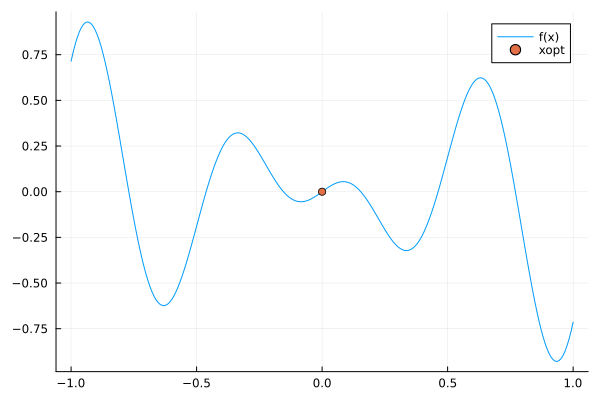

In [434]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 10.2, lb=-1, ub=1.)
# domain = dense_1D_discretization(lb=testfn.bounds[1,1], ub=testfn.bounds[1,2], stepsize=.01)
# testfn = vshift(testfn, -sum(testfn([x]) for x in domain) / length(domain))
# testfn = TestConstant(lbs=[0.], ubs=[1.])
# testfn = TestQuadratic1D()
tplot(testfn)

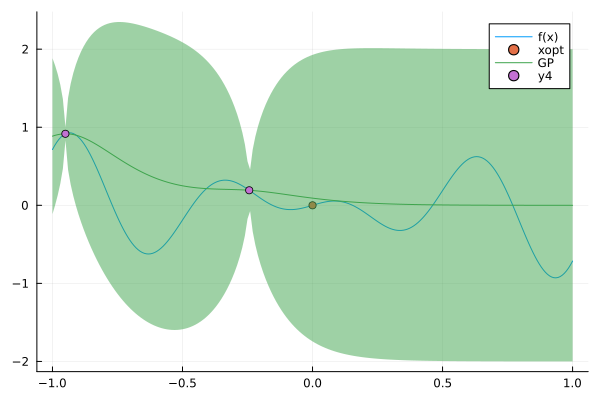

In [444]:
MC_SAMPLES = 5
NUMBER_OF_STARTS = 32
HORIZON = 1
USE_LDS = false
INITIAL_SAMPLES = 2

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-8
θinit = [0.]
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [1., .25])
# ψ = kernel_scale(kernel_matern52, [1., 3.])

lbs, ubs = get_bounds(testfn)
midpoint = (ubs + lbs) / 2
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=midpoint,
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hypers=θinit
)
es = ExperimentSetup(number_of_starts=NUMBER_OF_STARTS, tp=tp)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn(Xinit)
# Xinit = hcat(Xinit, [.5;;])
# yinit = vcat(yinit, [1.])
sur = Surrogate(ψ, Xinit, yinit, base_policy=EI(), σn2=σn2);
osur = fit_surrogate(ψ, Xinit, yinit, σn2=σn2);
# sur = optimize(sur, kernel_matern52, lowerbounds=[0.], upperbounds=[5.])

tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
scatter!(sur.X', sur.y)

## Visualizing Base Policy Solves along a Trajectory

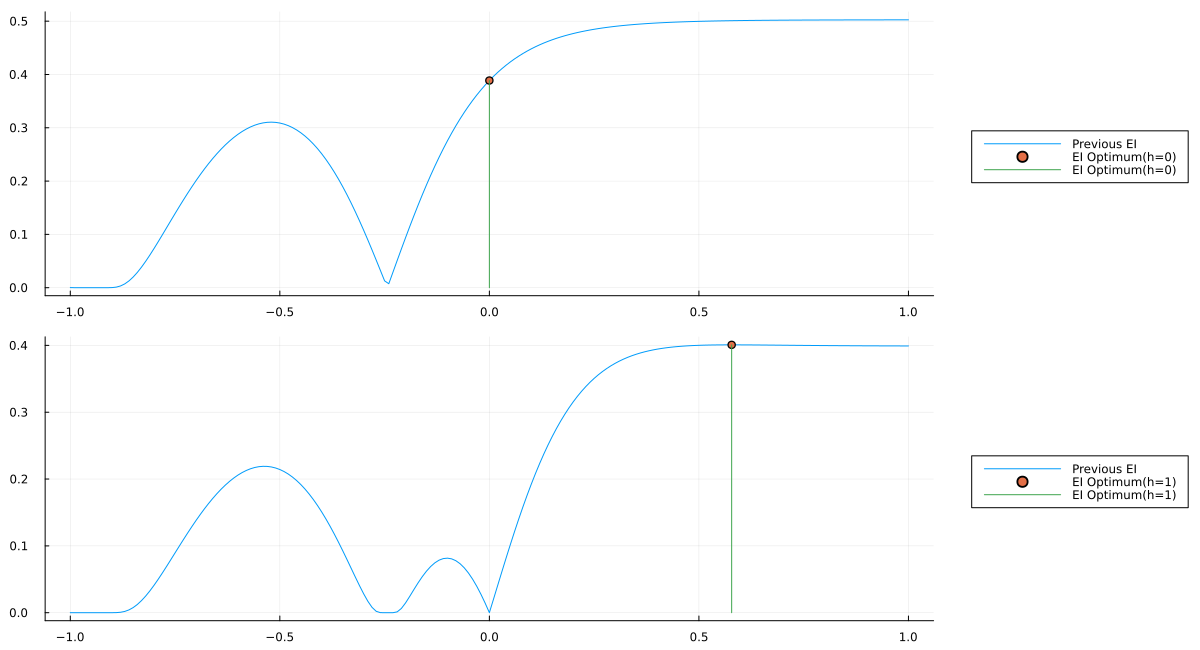

In [445]:
IS_DETERMINISTIC = true
# Construct the inner policy
base_policy = EI()
lbs, ubs = get_spatial_bounds(tp)

# Construct GP
sur = Surrogate(ψ, Xinit, yinit, base_policy=base_policy, σn2=σn2)

# Construct trajectory
AT = AdjointTrajectory(
    base_surrogate=sur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(AT),
    stdnormal=get_samples_rnstream(tp, sample_index=1),
    max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f,
    gradient=testfn.∇f,
    max_invocations=get_horizon(tp) + 1
)
attach_observable!(AT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)

# Adjoint Rollout
adjoint_rollout!(
    AT,
    spatial_lbs=lbs,
    spatial_ubs=ubs,
    xstarts=get_starts(es),
    get_observation=get_observable(AT)
)

all_plots = []

for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = eval(AT.fs([xx], θinit, fantasy_index=upto_index-1))
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    
    scatter!(
        [target_location],
        [eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    
    plot!(
        [target_location, target_location],
        [0., eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [446]:
etos = []
old_etos = []
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)

for (index, xx) in enumerate(domain)
    print("|")
    set_starting_point!(tp, [xx])
    # Adjoint mode
    if IS_DETERMINISTIC
        eto = deterministic_simulate_trajectory(
            sur,
            tp,
            inner_solve_xstarts=get_starts(es),
            func=testfn.f,
            grad=testfn.∇f
        )
    else
        eto = simulate_adjoint_trajectory(
            sur,
            tp,
            inner_solve_xstarts=get_starts(es),
            resolutions=get_container(es, symbol=:f),
            spatial_gradients_container=get_container(es, symbol=:grad_f),
            hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
        )
        eto2 = simulate_forward_trajectory(osur, tp, get_starts(es), resolutions=resolutions, gradient_resolutions=gresolutions)
        push!(old_etos, eto2)
    end
    push!(etos, eto)
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

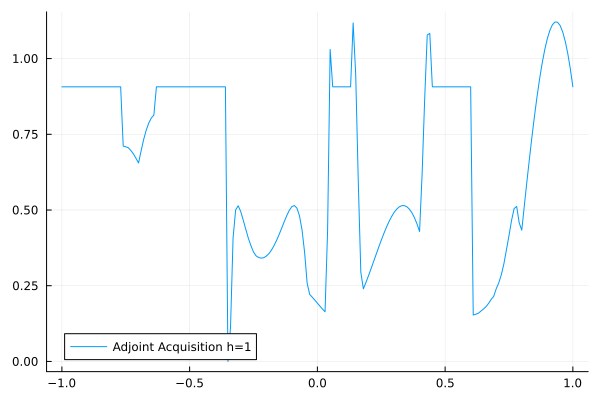

In [447]:
plot(
    domain,
    [mean(eto) for eto in etos],
    ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [oo[1] for oo in old_etos],
#     label="Forward Acquisition h=$(get_horizon(tp))"
# )

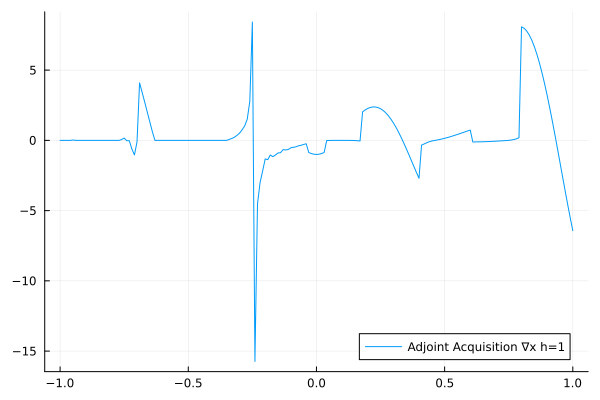

In [448]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)
# plot!(
#     domain,
#     [oo[3][1] for oo in old_etos],
#     label="Forward Acquisition ∇x h=$(get_horizon(tp))"
# )

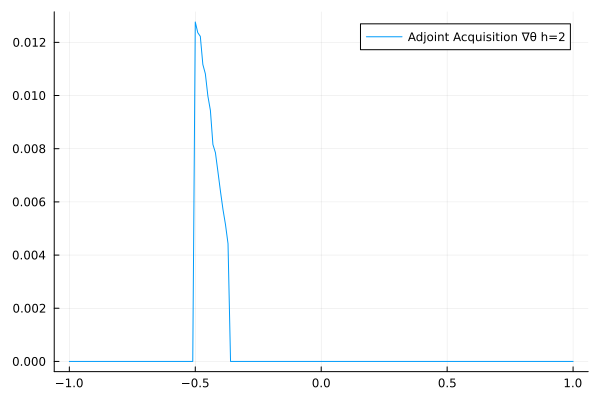

In [433]:
plot(
    domain,
    [first(gradient(eto, wrt_hypers=true)) for eto in etos],
    ribbons=[
        first(std_gradient(eto, wrt_hypers=true)) / sqrt(MC_SAMPLES)
        for eto in etos
    ],
    label="Adjoint Acquisition ∇θ h=$(get_horizon(tp))",
)

In [154]:
minimizers = []

for x in eachcol(get_starts(es))
    if IS_DETERMINISTIC
        push!(minimizers, 
            deterministic_solve(
                optimizer=Adam(),
                surrogate=sur,
                tp=tp,
                es=es,
                start=x,
                func=testfn.f,
                grad=testfn.∇f
            )
        )
    else
        push!(minimizers, 
            stochastic_solve(
                optimizer=Adam(),
                surrogate=sur,
                tp=tp,
                es=es,
                start=x
            )
        )
    end
end

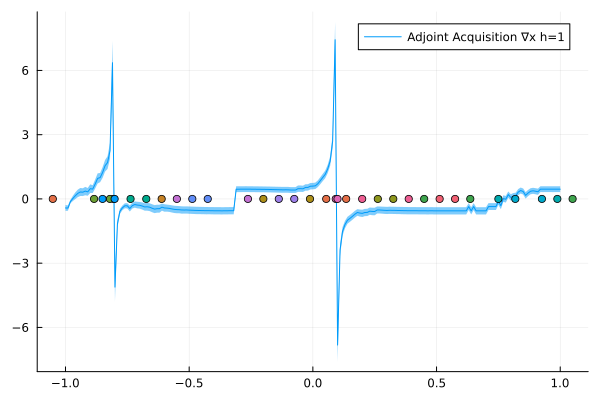

In [155]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)
scatter!(minimizers, zeros(NUMBER_OF_STARTS), label=nothing)